In [222]:
# !pip install -q ddsketch cvxpy medmnist

In [123]:
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import cvxpy
import ddsketch
import medmnist
import pandas as pd
import torch
import numpy as np
from ddsketch import DDSketch

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
reload(cp)
reload(ts)

<module 'src.temperature' from '/Users/clu/repos/federated-conformal/src/temperature.py'>

In [2]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [3]:
path_to_experiments = Path('../experiments/')

In [131]:
dataset = 'fitzpatrick'

model = 'resnet18'

num_classes = 114
val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}' / 'val_df.csv')
test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}' / 'test_df.csv')
    

def load_scores(experiment: Path = None, dataset=None) -> dict:
    try:
        print(experiment)
        load = lambda p: torch.load(p, map_location=torch.device('cpu'))
        stage = 'stage2' if 'tct' in experiment.name else 'stage1'
        val_scores = load(*(experiment / 'scores').glob(f'*_{stage}_val_scores.pth'))
        val_targets = load(*(experiment / 'scores').glob(f'*_{stage}_val_targets.pth'))
        test_scores = load(*(experiment / 'scores').glob(f'*_{stage}_test_scores.pth'))
        test_targets = load(*(experiment / 'scores').glob(f'*_{stage}_test_targets.pth'))
        if dataset == 'pathmnist':
            k = round(0.1 * len(test_targets))
            # k = 50 * len(clients_class_map)
            return dict(val_scores=test_scores[:k], val_targets=test_targets[:k], test_scores=test_scores[k:], test_targets=test_targets[k:])
        else:
            return dict(val_scores=val_scores, val_targets=val_targets, test_scores=test_scores, test_targets=test_targets)
    except Exception as e:
        print(e)
        return None

experiments = {
    'central': load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
    'tct': load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
    'fedavg': load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
    'tct_iid': load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
    'fedavg_iid': load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition'), dataset=dataset),
}
experiments = {k: v for k, v in experiments.items() if v is not None}
if dataset == 'fitzpatrick':
    # for k, v in experiments.items():
    #     if k == 'tct':
    #         experiments[k]['test_scores'] = v['test_scores'][index]
    #         experiments[k]['test_targets'] = v['test_targets'][index]
    assert (experiments['tct']['val_targets'].numpy() == val_df['target'].values).sum()
    assert (experiments['tct']['test_targets'].numpy() == test_df['target'].values).sum()
    
for k, v in experiments.items():
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    temp = ts.temp_scale(val_logits, val_targets, plot=False)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    experiments[k]['temp_val_scores'] = val_scores
    experiments[k]['temp_test_scores'] = test_scores

../experiments/fitzpatrick_central_resnet18
../experiments/fitzpatrick_tct_resnet18
../experiments/fitzpatrick_fedavg_resnet18
../experiments/fitzpatrick_tct_resnet18_iid_partition
<lambda>() missing 1 required positional argument: 'p'
None
'NoneType' object has no attribute 'name'


In [137]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    # total = targets.size(0)
    total = targets.shape[0]
    return (correct.sum() / total).item()

for k, v in experiments.items():
    print(f"\n{k.upper().center(20, '=')}")
    print(f" val accuracy {accuracy(v['val_scores'], v['val_targets']):.0%}")
    print(f"test accuracy {accuracy(v['test_scores'], v['test_targets']):.0%}")



======CENTRAL=======
 val accuracy 63%
test accuracy 62%

========TCT=========
 val accuracy 59%
test accuracy 61%

=======FEDAVG=======
 val accuracy 38%
test accuracy 40%

======TCT_IID=======
 val accuracy 65%
test accuracy 63%

=====FEDAVG_IID=====
 val accuracy 63%
test accuracy 61%


## Calibrate on one client

In [113]:
alpha = 0.05
k = 4
allow_empty_sets = True
cal_index = val_df.aggregated_fitzpatrick_scale == k
test_index = test_df.aggregated_fitzpatrick_scale == 6
val_scores = experiments['fedavg']['temp_val_scores']
test_scores = experiments['fedavg']['temp_test_scores']
val_targets = experiments['fedavg']['val_targets']
test_targets = experiments['fedavg']['test_targets']
q = cp.calibrate_lac(val_scores[cal_index], val_targets[cal_index], alpha=alpha, )
q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha, )
cal_psets = cp.inference_lac(test_scores[test_df.aggregated_fitzpatrick_scale == k], q, allow_empty_sets=allow_empty_sets)
test_psets = cp.inference_lac(test_scores[test_index], q, allow_empty_sets=allow_empty_sets)

cal_coverage = cp.coverage(cal_psets, test_targets[test_df.aggregated_fitzpatrick_scale == k])
cal_size = cp.size(cal_psets)
test_coverage = cp.coverage(test_psets, test_targets[test_index])
test_size = cp.size(test_psets)

print(f'skin type 3\t {cal_coverage:.2f}  |  {cal_size:.1f}')
print(f'skin type 6\t {test_coverage:.2f}  |  {test_size:.1f}')

skin type 3	 0.97  |  67.4
skin type 6	 0.92  |  78.7


In [46]:
val_df.three_partition_label.value_counts()

non-neoplastic    421
benign             65
malignant          64
Name: three_partition_label, dtype: int64

In [29]:
val_scores.shape

torch.Size([550, 114])

In [143]:
# dataset = 'mnist'
# dataset = 'svhn'
dataset = 'fashion'
# dataset = 'cifar10'
dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'

model = 'small_resnet14'

if dataset in ('mnist', 'svhn', 'cifar10', 'fashion'):
    clients_class_map = {
        'client_1': [0],
        'client_2': [1],
        'client_3': [2],
        'client_4': [3],
        'client_5': [4],
        'client_6': [5],
        'client_7': [6],
        'client_8': [7],
        'client_9': [8],
        'client_10': [9],
    }
    num_classes = 10
elif dataset == 'cifar100':
    num_classes = 100
    clients_class_map = {
        "client_1": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        "client_2": [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        "client_3": [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        "client_4": [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        "client_5": [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        "client_6": [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        "client_7": [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        "client_8": [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        "client_9": [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        "client_10": [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
    }
    
elif dataset in ('bloodmnist', 'tissuemnist'):
    clients_class_map = {
        'client_1': [0],
        'client_2': [1],
        'client_3': [2],
        'client_4': [3],
        'client_5': [4],
        'client_6': [5],
        'client_7': [6],
        'client_8': [7],
    }
    num_classes = 8
elif dataset == 'dermamnist':
    clients_class_map = {
        'client_1': [0],
        'client_2': [1],
        'client_3': [2],
        'client_4': [3],
        'client_5': [4],
        'client_6': [5],
        'client_7': [6],
    }
    num_classes = 7
elif dataset == 'pathmnist':
    clients_class_map = {
        'client_1': [0],
        'client_2': [1],
        'client_3': [2],
        'client_4': [3],
        'client_5': [4],
        'client_6': [5],
        'client_7': [6],
        'client_8': [7],
        'client_9': [8],
    }
    num_classes = 9
    

def load_scores(experiment: Path = None, dataset=None) -> dict:
    try:
        print(experiment)
        load = lambda p: torch.load(p, map_location=torch.device('cpu'))
        stage = 'stage2' if 'tct' in experiment.name else 'stage1'
        val_scores = load(*(experiment / 'scores').glob(f'*_{stage}_val_scores.pth'))
        val_targets = load(*(experiment / 'scores').glob(f'*_{stage}_val_targets.pth'))
        test_scores = load(*(experiment / 'scores').glob(f'*_{stage}_test_scores.pth'))
        test_targets = load(*(experiment / 'scores').glob(f'*_{stage}_test_targets.pth'))
        if dataset == 'pathmnist':
            k = round(0.1 * len(test_targets))
            # k = 50 * len(clients_class_map)
            return dict(val_scores=test_scores[:k], val_targets=test_targets[:k], test_scores=test_scores[k:], test_targets=test_targets[k:])
        else:
            return dict(val_scores=val_scores, val_targets=val_targets, test_scores=test_scores, test_targets=test_targets)
    except Exception as e:
        print(e)
        return None

experiments = {
    'central': load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
    'tct': load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
    'fedavg': load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
    'tct_iid': load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
    'fedavg_iid': load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition'), dataset=dataset),
}
experiments = {k: v for k, v in experiments.items() if v is not None}


../experiments/cifar100_central_small_resnet14
../experiments/cifar100_tct_small_resnet14
../experiments/cifar100_fedavg_small_resnet14
../experiments/cifar100_tct_small_resnet14_iid_partition
../experiments/cifar100_fedavg_small_resnet14_iid_partition


In [144]:
for k, v in experiments.items():
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    temp = ts.temp_scale(val_logits, val_targets, plot=False)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    experiments[k]['temp_val_scores'] = val_scores
    experiments[k]['temp_test_scores'] = test_scores
    
   

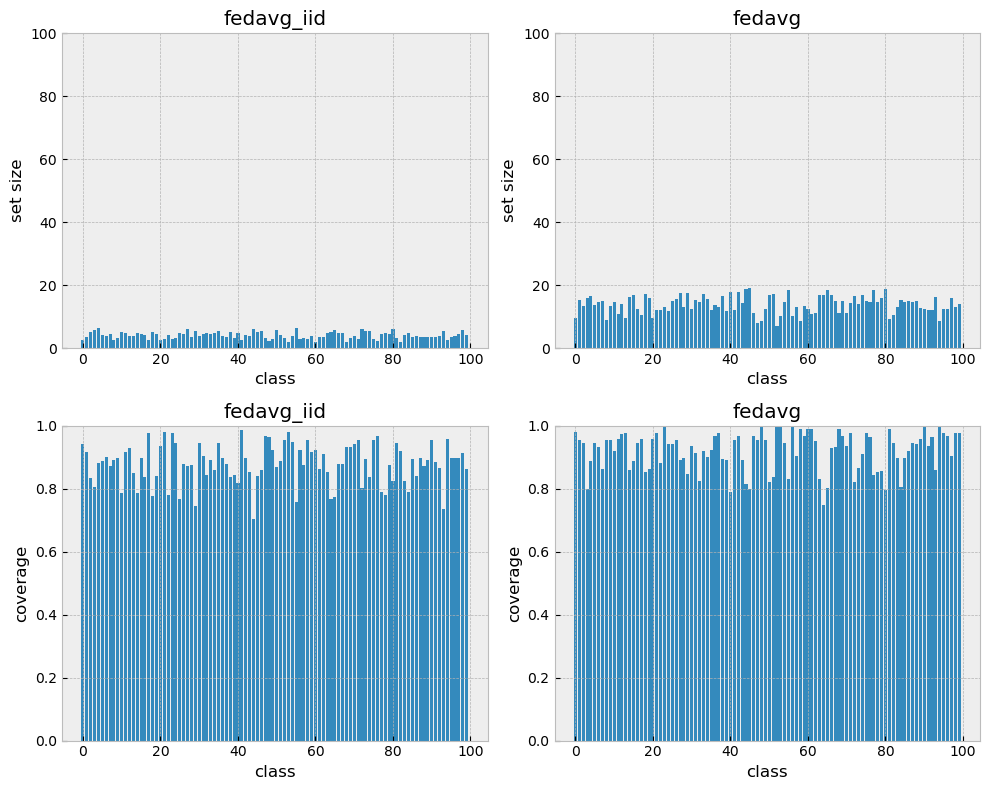

In [135]:
exps = ['central', 'fedavg_iid', 'fedavg']
exps = ['fedavg_iid', 'fedavg']

fig, ax = plt.subplots(ncols=len(exps), nrows=2, figsize=(10, 8))
for i, exp in enumerate(exps):
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    q = cp.calibrate_lac(val_scores, val_targets, alpha=0.1)
    psets = cp.inference_lac(test_scores, q)

    ax[0, i].set_title(exp)
    ax[0, i].bar(range(num_classes), cp.efficiency_by_class(psets, test_targets, num_classes=num_classes).values())
    ax[0, i].set_xlabel('class')
    ax[0, i].set_ylabel('set size')
    ax[0, i].set_ylim(0, num_classes)
    # ax[i].set_ylim(0, 20)
    # plt.bar(range(num_classes), test_scores.std(0))
    
    ax[1, i].set_title(exp)
    ax[1, i].bar(range(num_classes), cp.coverage_by_class(psets, test_targets, num_classes=num_classes).values())
    ax[1, i].set_xlabel('class')
    ax[1, i].set_ylabel('coverage')
    ax[1, i].set_ylim(0., 1)
plt.tight_layout()
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


fedavg_iid 0.9437777996063232
fedavg_iid 7.5273332595825195
fedavg 0.9581111073493958
fedavg 21.082111358642578


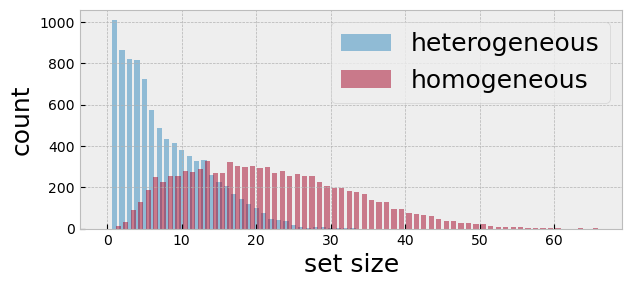

In [178]:
alpha = 0.05
# alpha = 0.1
fontsize = 18
allow_empty_sets = False 

fig, ax = plt.subplots(ncols=1, figsize=(7, 3))
# fig.suptitle(exp + ' lac', fontsize=fontsize+4, y=1.10)

for i, exp in enumerate(('fedavg_iid', 'fedavg')):
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha)
    psets = cp.inference_lac(test_scores, q, allow_empty_sets=allow_empty_sets)
    size_counts = psets.sum(1).bincount().tolist()
    print(exp, cp.coverage(psets, test_targets))
    print(exp, cp.size(psets))
    if exp == 'fedavg_iid':
        label = 'heterogeneous'
        offset = 0
    elif exp == 'fedavg':
        label = 'homogeneous'
        offset = 0.5
    ax.bar(np.arange(len(size_counts)) + offset, size_counts, width=0.7, label=label, alpha=0.5)
    # ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
    ax.set_xlabel('set size', fontsize=fontsize)
    ax.set_ylabel('count', fontsize=fontsize)
    # ax.set_xlim(0, 50)
        
    # fig.tight_layout()
plt.legend(fontsize=fontsize, fancybox=True)
plt.subplots_adjust(bottom=0.15)
plt.savefig('/Users/clu/Desktop/heterogeneous-set-sizes.eps')
plt.show()
